In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 📂 Directorio de la carpeta CLEAN
clean_path = "/Users/chants/Desktop/DM_TEL_cucalon/Data/clean/"

# 📌 --- CARGAR LAS TABLAS ---
fact_billing = pd.read_csv(clean_path + "fact_billing.csv")
dim_users = pd.read_csv(clean_path + "dim_users.csv")
dim_plans = pd.read_csv(clean_path + "dim_plans.csv")

# Convertir mes a formato datetime
fact_billing["month"] = pd.to_datetime(fact_billing["month"].astype(str))

print("✅ Datos cargados correctamente.")

# 📌 --- CREACIÓN DE CARACTERÍSTICAS ---

## 🔹 COSTOS EXTRA TOTALES
fact_billing["overage_cost"] = (
    fact_billing["overage_calls_cost"] + fact_billing["overage_messages_cost"] + fact_billing["overage_internet_cost"]
)

## 🔹 PROMEDIOS Y DESVIACIÓN ESTÁNDAR POR USUARIO
features = fact_billing.groupby("user_id").agg({
    "total_calls_duration": ["mean", "std"],
    "total_messages": ["mean", "std"],
    "mb_used": ["mean", "std"],
    "overage_cost": ["mean", "std"],
    "total_cost": ["mean"]
}).reset_index()

## 🔹 RENOMBRAR COLUMNAS
features.columns = ["user_id",
                    "total_calls_duration_mean", "total_calls_duration_std",
                    "total_messages_mean", "total_messages_std",
                    "mb_used_mean", "mb_used_std",
                    "overage_cost_mean", "overage_cost_std",
                    "total_cost_mean"]

## 🔹 USO DEL ÚLTIMO MES Y DEL MES ANTERIOR
latest_month = fact_billing["month"].max()
previous_month = latest_month - pd.DateOffset(months=1)

latest_data = fact_billing[fact_billing["month"] == latest_month]
previous_data = fact_billing[fact_billing["month"] == previous_month]

latest_data = latest_data[["user_id", "total_calls_duration", "total_messages", "mb_used", "total_cost"]]
previous_data = previous_data[["user_id", "total_calls_duration", "total_messages", "mb_used", "total_cost"]]

latest_data = latest_data.rename(columns={
    "total_calls_duration": "total_calls_duration_last_month",
    "total_messages": "total_messages_last_month",
    "mb_used": "mb_used_last_month",
    "total_cost": "total_cost_last_month"
})

previous_data = previous_data.rename(columns={
    "total_calls_duration": "total_calls_duration_prev_month",
    "total_messages": "total_messages_prev_month",
    "mb_used": "mb_used_prev_month",
    "total_cost": "total_cost_prev_month"
})

## 🔹 UNIR DATOS DEL ÚLTIMO MES Y DEL MES ANTERIOR
features = features.merge(latest_data, on="user_id", how="left")
features = features.merge(previous_data, on="user_id", how="left")

## 🔹 TASA DE CAMBIO ENTRE EL MES PASADO Y EL ANTERIOR
features["calls_change_rate"] = (features["total_calls_duration_last_month"] - features["total_calls_duration_prev_month"]) / features["total_calls_duration_prev_month"]
features["messages_change_rate"] = (features["total_messages_last_month"] - features["total_messages_prev_month"]) / features["total_messages_prev_month"]
features["mb_change_rate"] = (features["mb_used_last_month"] - features["mb_used_prev_month"]) / features["mb_used_prev_month"]

# Reemplazar valores NaN por 0 (para usuarios sin datos previos)
features.fillna(0, inplace=True)

## 🔹 UNIR INFORMACIÓN DE USUARIOS Y PLANES
features = features.merge(dim_users[["user_id", "plan", "age", "churn_status"]], on="user_id", how="left")
features = features.merge(dim_plans[["plan_name", "usd_monthly_pay"]], left_on="plan", right_on="plan_name", how="left")

# Eliminar columna duplicada
features.drop(columns=["plan_name"], inplace=True)

## 🔹 BINNING DE EDAD (Segmentación)
features["age_group"] = pd.cut(features["age"], bins=[0, 30, 50, 100], labels=["Joven", "Adulto", "Senior"])

## 🔹 BINNING DE GASTO TOTAL (Segmentación)
features["cost_group"] = pd.cut(features["total_cost_mean"], bins=[0, 50, 100, 200, 500], labels=["Bajo", "Medio", "Alto", "Muy Alto"])

## 🔹 ESCALADO Y NORMALIZACIÓN DE VARIABLES NUMÉRICAS
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

num_cols = [
    "total_calls_duration_mean", "total_calls_duration_std",
    "total_messages_mean", "total_messages_std",
    "mb_used_mean", "mb_used_std",
    "overage_cost_mean", "overage_cost_std",
    "total_cost_mean", "total_calls_duration_last_month",
    "total_messages_last_month", "mb_used_last_month",
    "total_cost_last_month", "calls_change_rate",
    "messages_change_rate", "mb_change_rate"
]

features[num_cols] = scaler.fit_transform(features[num_cols])  # Estandarización

features[num_cols] = minmax_scaler.fit_transform(features[num_cols])  # Normalización

## 🔹 CODIFICACIÓN DE VARIABLES CATEGÓRICAS (One-Hot Encoding)
features = pd.get_dummies(features, columns=["plan", "churn_status", "age_group", "cost_group"], drop_first=True)

print("✅ Features creadas correctamente.")

# 📌 --- EXPORTAR PARA MODELADO ---
features.to_csv(clean_path + "features_dataset.csv", index=False)

print("✅ Dataset final de features guardado en:", clean_path)



✅ Datos cargados correctamente.


KeyError: 'overage_calls_cost'

In [ ]:
import pandas as pd

# Directorio de la carpeta 
clean_path = "/Users/chants/Desktop/DM_TEL_cucalon/Data/ml/"

# 📌 --- Cargar el dataset de features ---
df_features = pd.read_csv(clean_path + "features_dataset.csv")

# 📌 --- Revisar datos cargados ---
print("✅ Dimensiones del dataset:", df_features.shape)
print("\n✅ Primeras filas:")
print(df_features.head())

# 📌 --- Revisar valores nulos ---
print("\n❗ Valores nulos por columna:")
print(df_features.isnull().sum())

# 📌 --- Revisar tipos de datos ---
print("\n🔍 Tipos de datos:")
print(df_features.dtypes)


✅ Dimensiones del dataset: (500, 30)

✅ Primeras filas:
   user_id  total_calls_duration_mean  total_calls_duration_std  \
0     1000                   0.015027                  0.066041   
1     1001                   0.190359                  0.312911   
2     1002                   0.089395                  0.243133   
3     1003                   0.114127                  0.501558   
4     1004                   0.290097                  0.291082   

   total_messages_mean  total_messages_std  mb_used_mean  mb_used_std  \
0             0.008540            0.037530      0.004874     0.024503   
1             0.160714            0.259585      0.206167     0.404271   
2             0.068323            0.170332      0.103274     0.297665   
3             0.038820            0.170593      0.069316     0.348498   
4             0.137422            0.145464      0.400741     0.488802   

   overage_cost_mean  overage_cost_std  total_cost_mean  ...  mb_change_rate  \
0           0.000000  

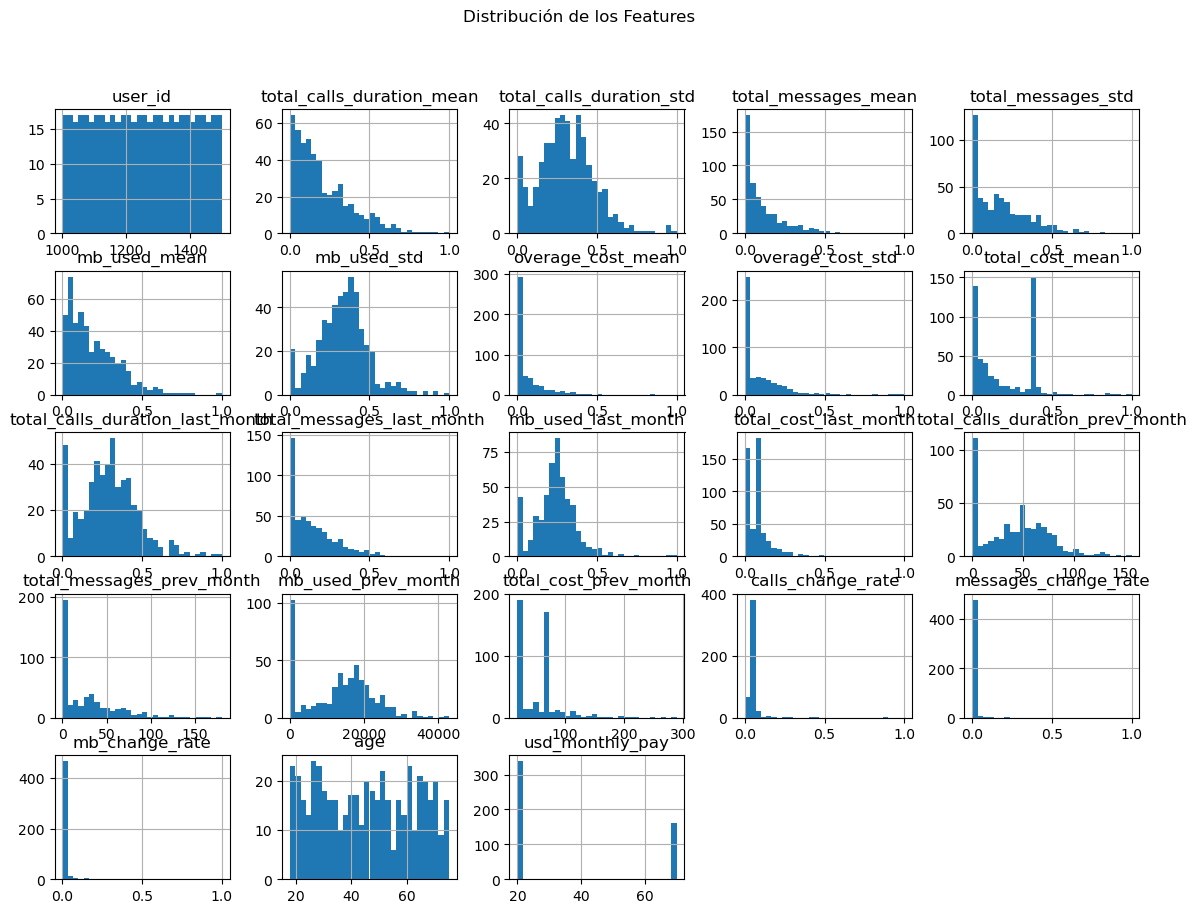

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Histograma de los principales features ---
df_features.hist(figsize=(14,10), bins=30)
plt.suptitle("Distribución de los Features")
plt.show()
